In [30]:
import numpy as np
import pandas as pd

Definimos las variables

In [40]:
N = 4*12 # Número de meses
r = np.zeros([N+1, N+1]) # Arbol Binomial
Q = np.zeros([N+1, N+1]) # Precios Arrow-Debreu
theta = np.zeros(N+1) # Drift
dt = 1/12 # Delta t
sigma = 0.02952452925930132 # Volatilidad

Llenar estado inicial

In [41]:
r[0][0] = 0.04761 # Tasa inicial
Q[0][0] = 1 # Precio inicial

# Leer factores de descuento
with open('df.txt', 'r') as archivo:
    discount_factors = archivo.read()
    discount_factors = discount_factors.split(',')
    for i in range(len(discount_factors)):
        discount_factors[i] = float(discount_factors[i])
    P = np.array(discount_factors)


theta[0] = (1/dt ** 2) * (np.log((np.exp(-r[0][0] * dt) + np.exp(-(r[0][0] + 2 * sigma * np.sqrt(dt)) * dt)) / (2 * P[1]))) + sigma/np.sqrt(dt)

Tasas nivel 1

In [42]:
r[1][1] = r[0][0] + theta[0]*dt + sigma*np.sqrt(dt)
r[0][1] = r[0][0] + theta[0]*dt - sigma*np.sqrt(dt)

Iteración de cada nivel

In [44]:
for j in range(1,N):

    # Precios Arrow-Debreu
    for i in range(0, j+1):
        if i == 0:
            Q[i][j] = np.exp(-r[i][j] * dt) * 0.5 * Q[i][j-1]
        elif i == j:
            Q[i][j] = np.exp(-r[i][j] * dt) * 0.5 * Q[j-1][j-1]
        else:
            Q[i][j] = np.exp(-r[i][j] * dt) * 0.5 * (Q[i-1][j-1] + Q[i][j-1])
    
    # f auxiliar
    f = Q[0][j]*np.exp(-r[0][j] * dt) + sum([(Q[k-1][j] + Q[k][j])*np.exp(-r[k][j] * dt) for k in range(1, j+1)]) + Q[j][j]*np.exp(-(r[0][0] + 2 * sigma * np.sqrt(dt)) * dt)
    # theta
    theta[j] = (1/dt ** 2) * np.log(f / (2 * P[j+1])) + sigma/np.sqrt(dt)

    # Tasas
    for i in range(0, j+1):
        r[i][j+1] = r[i][j] + theta[j]*dt - sigma*np.sqrt(dt)
    r[j+1][j+1] = r[j][j] + theta[j]*dt + sigma*np.sqrt(dt)

In [46]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def plot_ho_lee_lattice(r: np.ndarray, dt: float, title="Lattice de Ho–Lee"):
    """
    r: matriz triangular (n+1 x n+1) con r[i,j] definido para i<=j (NaN fuera)
       r en DECIMAL (p.ej. 0.0184 = 1.84%)
    dt: tamaño del paso en años (ej: 1/12 si mensuales, 0.25 si trimestrales)
    """
    n = r.shape[0] - 1
    T = np.arange(n + 1) * dt

    fig, ax = plt.subplots(figsize=(10, 5))

    # Dibujar aristas (padre j -> hijos en j+1)
    for j in range(n):
        for i in range(j + 1):
            if np.isfinite(r[i, j]) and np.isfinite(r[i, j+1]):
                ax.plot([T[j], T[j+1]],
                        [r[i, j], r[i, j+1]],
                        color="red", lw=0.8)
            if np.isfinite(r[i, j]) and np.isfinite(r[i+1, j+1]):
                ax.plot([T[j], T[j+1]],
                        [r[i, j], r[i+1, j+1]],
                        color="red", lw=0.8)

    # (Opcional) marcar nodos
    for j in range(n + 1):
        y = r[:j+1, j]
        x = np.full(j + 1, T[j])
        ax.plot(x, y, "o", ms=2, color="black")

    # Formato ejes
    ax.set_xlim(T[0], T[-1])
    ymin = np.nanmin(r); ymax = np.nanmax(r)
    ylim = max(abs(ymin), abs(ymax))
    pad = 0.05 * (ymax - ymin if np.isfinite(ymax - ymin) and ymax != ymin else 0.02)
    ax.set_ylim(-ylim - pad, ylim + pad)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # muestra % (r en decimal)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Plazo (meses)")
    ax.set_ylabel("Tasa")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

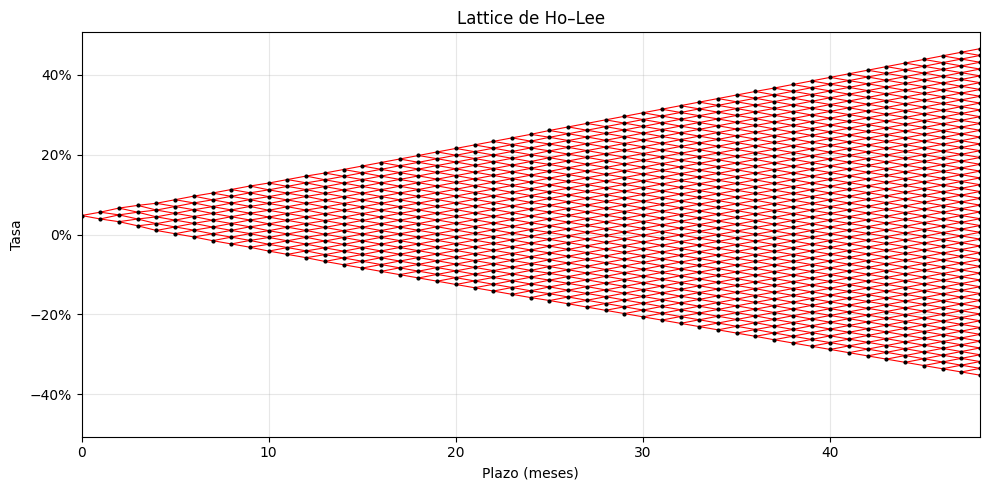

In [47]:
plot_ho_lee_lattice(r, 1)